In [77]:
# Installing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Part I - Exploratory data analysis

In [2]:
data = pd.read_json('logins.json')

In [3]:
data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
data['15_min_interval'] = data['login_time'].dt.floor('15T')

/var/folders/5y/xktw_n857vb915jnv6mlqv6c0000gn/T/ipykernel_17993/4223370846.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data['15_min_interval'] = data['login_time'].dt.floor('15T')


In [7]:
data.head()

,login_time,15_min_interval
0,1970-01-01 20:13:18,1970-01-01 20:00:00
1,1970-01-01 20:16:10,1970-01-01 20:15:00
2,1970-01-01 20:16:37,1970-01-01 20:15:00
3,1970-01-01 20:16:36,1970-01-01 20:15:00
4,1970-01-01 20:26:21,1970-01-01 20:15:00


In [11]:
grouped = data.groupby('15_min_interval').agg({'login_time':'count'}).reset_index()

<Axes: xlabel='15_min_interval'>

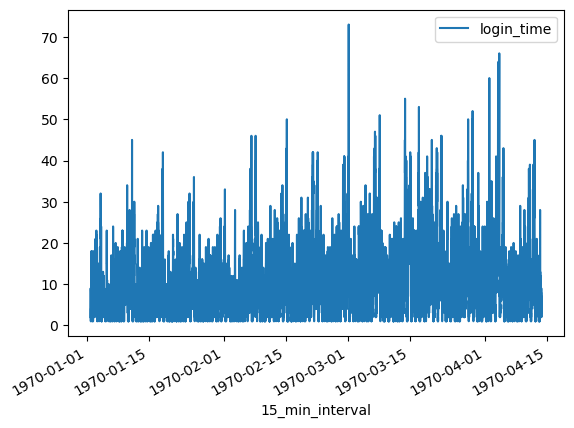

In [13]:
grouped.set_index('15_min_interval').plot()

In [27]:
data['month'] = data['login_time'].dt.month
data['day'] = data['login_time'].dt.day
data['date'] = data['login_time'].dt.date
data['day_of_week'] = data['login_time'].dt.weekday
data['hour'] = data['login_time'].dt.hour

In [28]:
data.head()

,login_time,15_min_interval,month,day,day_of_week,hour,date
0,1970-01-01 20:13:18,1970-01-01 20:00:00,1,1,3,20,1970-01-01
1,1970-01-01 20:16:10,1970-01-01 20:15:00,1,1,3,20,1970-01-01
2,1970-01-01 20:16:37,1970-01-01 20:15:00,1,1,3,20,1970-01-01
3,1970-01-01 20:16:36,1970-01-01 20:15:00,1,1,3,20,1970-01-01
4,1970-01-01 20:26:21,1970-01-01 20:15:00,1,1,3,20,1970-01-01


## Checking daily trend

In [59]:
grouped_date = data.groupby('date').agg({'login_time':'count'})
grouped_date = grouped_date.rename(columns={'login_time':'logins'})

In [60]:
# Checking if all dates are present in the data
full_date_range = pd.date_range(start='1970-01-01', end='1970-04-15', freq='D')
data_reindexed = grouped_date.reindex(full_date_range)
data_reindexed.isnull().sum()

logins    2
dtype: int64

In [62]:
data_reindexed[data_reindexed['logins'].isnull()==True]

,logins
1970-04-14,NaN
1970-04-15,NaN


April data is present only until Apr 13.

In [63]:
data_reindexed.head()

,logins
1970-01-01,112.0
1970-01-02,681.0
1970-01-03,793.0
1970-01-04,788.0
1970-01-05,459.0


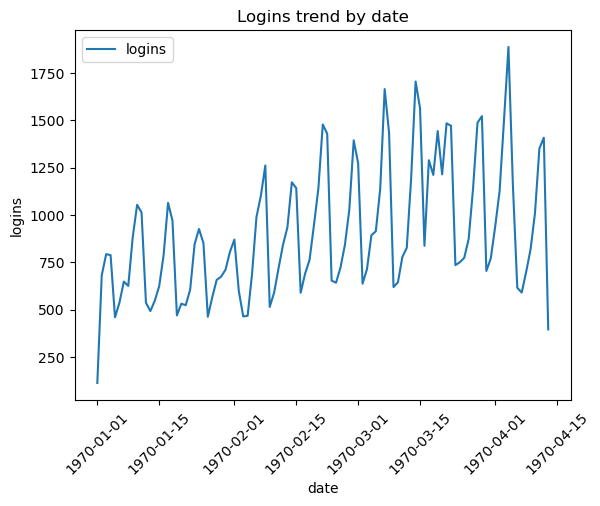

In [64]:
grouped_date.plot(rot=45)
plt.xlabel('date')
plt.ylabel('logins')
plt.title('Logins trend by date')
plt.show()

### Observations:
It looks like logins data has some seasonality, since there are cyclical ups and downs in logins number. I assume the behavior is different on weekends versus weekdays.

## Checking trend by day of week

In [66]:
grouped_dow = data.set_index('15_min_interval').groupby('day_of_week').agg({'login_time':'count'})
grouped_dow = grouped_dow.rename(columns={'login_time':'logins'})

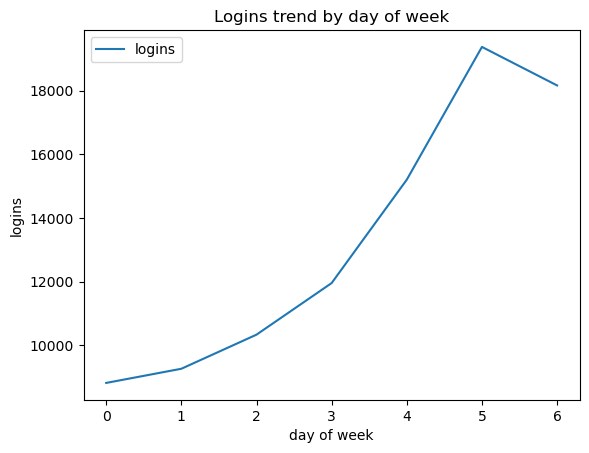

In [67]:
grouped_dow.plot()
plt.xlabel('day of week')
plt.ylabel('logins')
plt.title('Logins trend by day of week')
plt.show()

### Observations:
The number of logins is the highest on Saturdays with the close second highest on Sundays. From Monday to Saturday the number of logins is gradually increasing.

## Checking monthly trend

In [25]:
data['month'].value_counts()

month
3    33723
2    24673
1    21239
4    13507
Name: count, dtype: int64

In [68]:
grouped_monthly = data.groupby('month').agg({'login_time':'count'})
grouped_monthly = grouped_monthly.rename(columns={'login_time':'logins'})

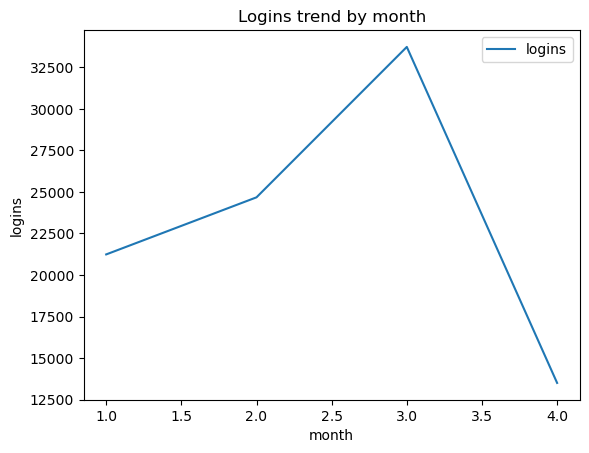

In [69]:
grouped_monthly.plot()
plt.xlabel('month')
plt.ylabel('logins')
plt.title('Logins trend by month')
plt.show()

### Observations:
The highest number of logins was in March.

In [70]:
data_mar = data[data['month']==3].groupby('date').agg({'login_time':'count'})
data_mar = data_mar.rename(columns={'login_time':'logins'})

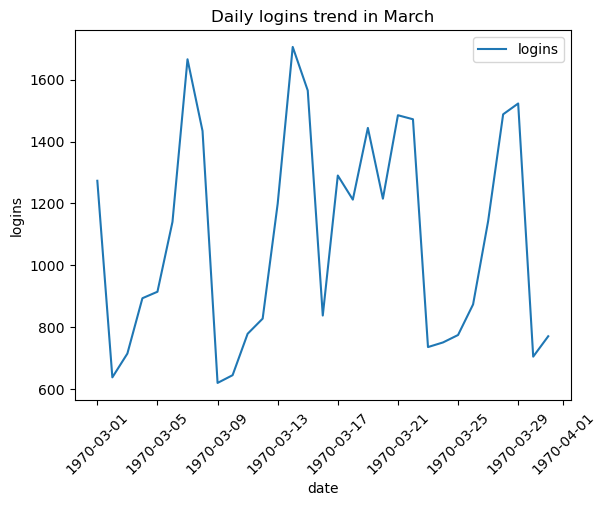

In [71]:
data_mar.plot(rot=45)
plt.xlabel('date')
plt.ylabel('logins')
plt.title('Daily logins trend in March')
plt.show()

### Observation:
There seem to be some anomaly in logins between Mar 17 and Mar 21 - perhaps some campaign during those days was driving user logins? 

## Checking hourly trend

In [72]:
grouped_hourly = data.groupby('hour').agg({'login_time':'count'})
grouped_hourly = grouped_hourly.rename(columns={'login_time':'logins'})

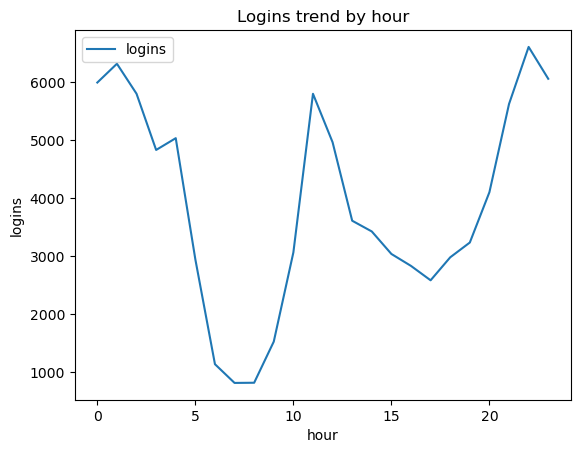

In [73]:
grouped_hourly.plot()
plt.xlabel('hour')
plt.ylabel('logins')
plt.title('Logins trend by hour')
plt.show()

### Observations:
There are dips and spikes in logins depending on the hour of day, with the highest number of logins during night hours and around lunch time, and the lowest number of logins in the mornings and afternoons.

# Part II ‐ Experiment and metrics design

## Context
Since both cities have complementing circadian rhythms the drivers from both partners naturally shall be driven by demand and pick up more trip requests in daytime in Metropolis area, and in night time in Gotham area. Since currently there is a two way toll over the bridge, the drivers may be reluctant to cross the bridge and tend to stay in same area. 

## Key measure of success
This trend could be measured by the average share of pickups in the initial (base) city for each driver during the day. Since the driving partners tend to stay exclusively in one city, initially this metric will be close to 100%. If experiment is successful and driver partners become driven by demand only then they start picking up trip requests from non-native city when the demand there increases (from Metropolis in daytime, and from Gotham in night time). Assuming the demand in both cities is equal, the share of pickups in base city shall drop to ~50%.

## Experiment design.

### how you will implement the experiment
Select randomly at least 30 drivers, 50% from one city and 50% from another. Provide them with free toll pass, run experiment for at least 14 days. Compare the results (average share of daily trips picked up in a base city) before and after the policy implementation.

### what statistical test(s) you will conduct to verify the significance of the observation
A paired t-test.

### how you would interpret the results and provide recommendations to the city operations team along with any caveats.
The null hypothesis is that removing tolls doesn't change the status quo - share of trip pickups from the base city will remain the same.
Alternative hypothesis is that removing tolls has an effect on drivers motivation to service both cities.

Paired T-test will return t-statistic and p-value. If p-value is less than chosen significance level (5% or 1%) then we will reject the null hypothesis and conclude that tolls removal did impact the drivers willingness to service both cities - the experiment is successful. 


# Part 3 ‐ Predictive modeling

In [101]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [78]:
data2 = pd.read_json('ultimate_data_challenge.json')
data2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [88]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [91]:
data2['signup_date'] = pd.to_datetime(data2['signup_date'])
data2['last_trip_date'] = pd.to_datetime(data2['last_trip_date'])

In [92]:
current_date = max(data2['last_trip_date'])

In [93]:
current_date

Timestamp('2014-07-01 00:00:00')

In [94]:
current_date - timedelta(days=30)

Timestamp('2014-06-01 00:00:00')

In [97]:
data2['active'] = data2['last_trip_date'] >= current_date - timedelta(days=30)

In [99]:
data2['active'].value_counts(normalize=True)

active
False    0.62392
True     0.37608
Name: proportion, dtype: float64

37.6% of customers who signed up in January were still active in the last 30 days.

### EDA

In [105]:
grouped_by_city = data2.groupby('city').active.mean().reset_index()
grouped_by_city.head()

,city,active
0,Astapor,0.255715
1,King's Landing,0.628134
2,Winterfell,0.351945


Text(0.5, 1.0, 'Retention rate by city')

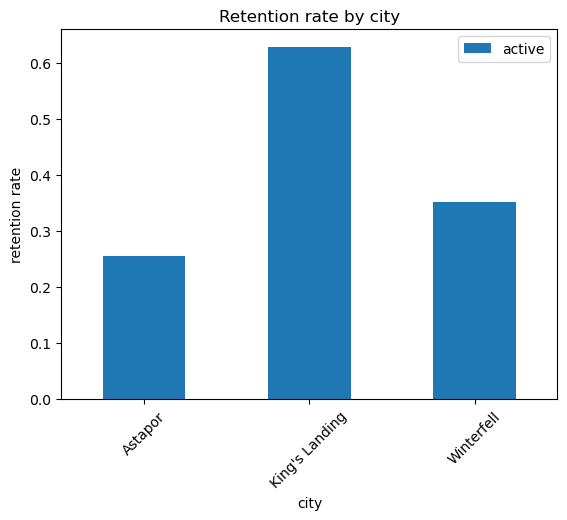

In [109]:
grouped_by_city.set_index('city').plot(kind='bar', rot=45)
plt.ylabel('retention rate')
plt.title('Retention rate by city')

Retention rate is the highest for customers from King's Landing and the lowest for Astapor. 

Text(0.5, 1.0, 'Retention rate by Ultimate Black user status')

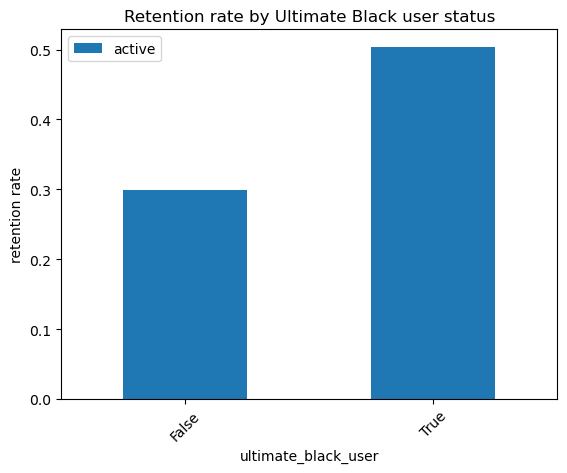

In [110]:
grouped_black = data2.groupby('ultimate_black_user').active.mean().reset_index()
grouped_black.set_index('ultimate_black_user').plot(kind='bar', rot=45)
plt.ylabel('retention rate')
plt.title('Retention rate by Ultimate Black user status')

Retention rate is 60% higher for Ultimate Black users

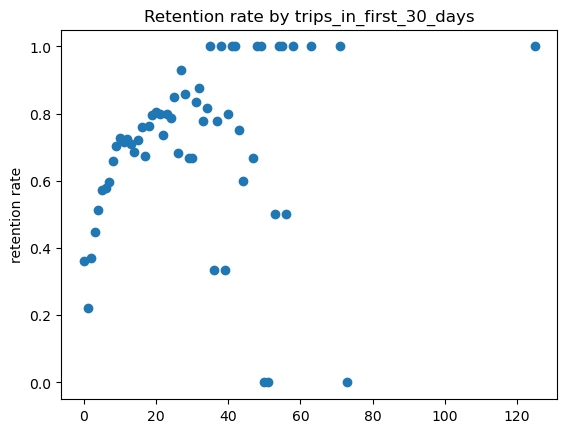

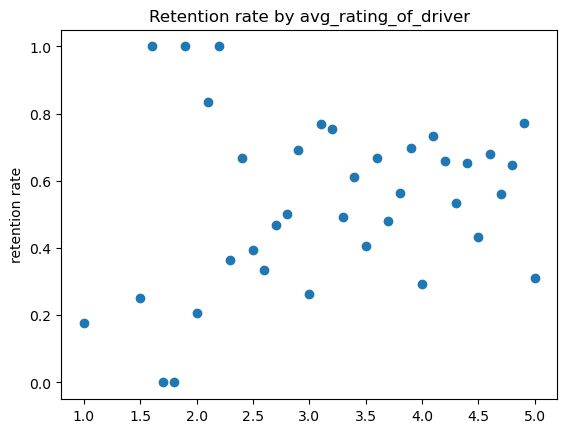

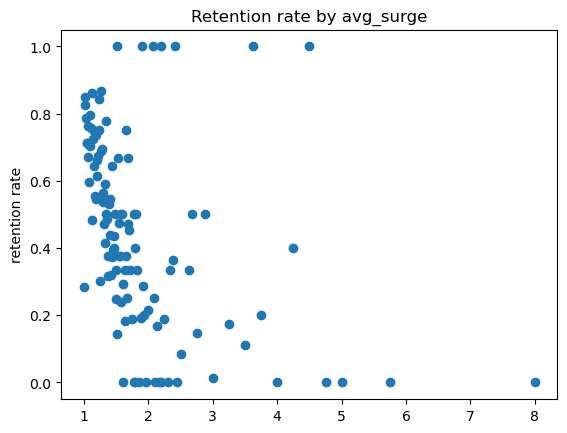

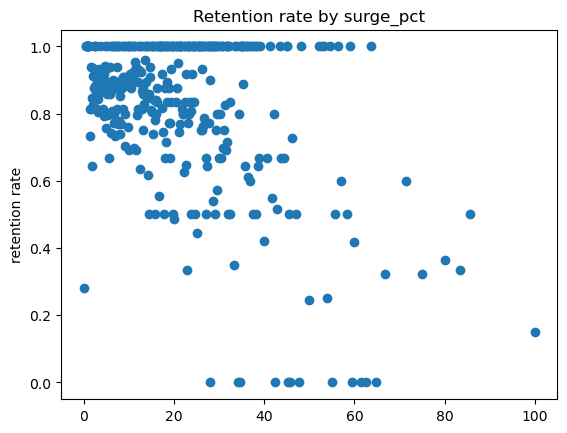

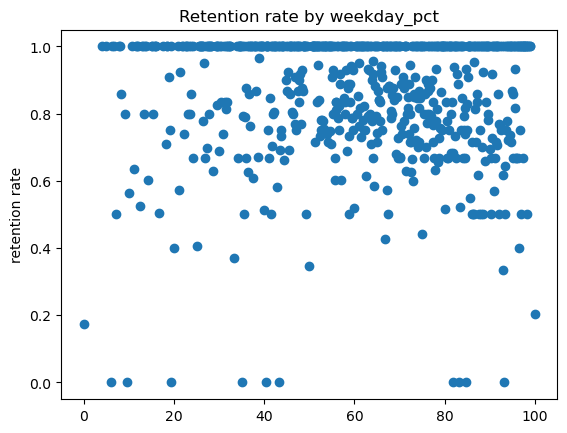

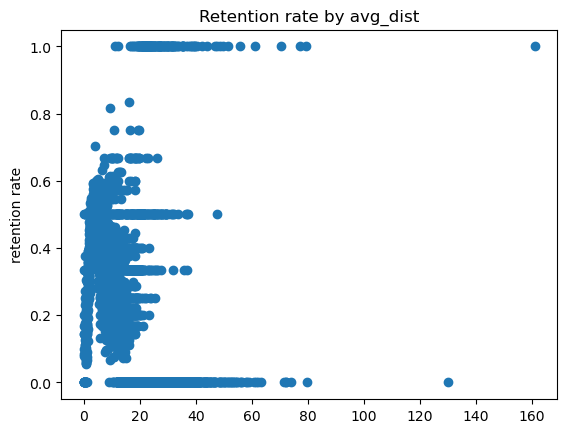

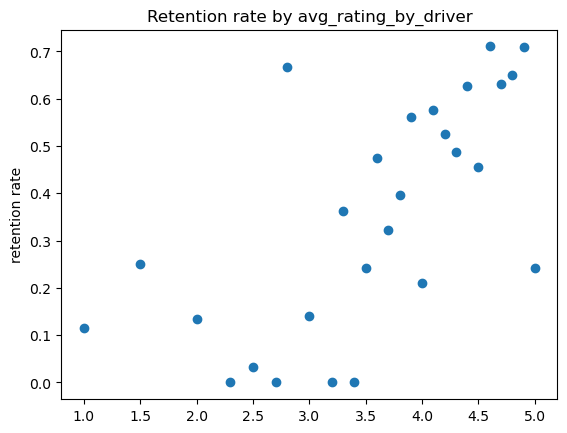

In [123]:
num_vars = ['trips_in_first_30_days','avg_rating_of_driver','avg_surge','surge_pct','weekday_pct','avg_dist','avg_rating_by_driver']
for var in num_vars:
    grouped_data = data2.groupby(var).active.mean().reset_index()
    plt.scatter(grouped_data[var],grouped_data['active'])
    plt.ylabel('retention rate')
    plt.title(f'Retention rate by {var}')
    plt.show()
 

There seems to be moderate positive relationship between retention rate (rr) and number of trips in the first 30 days, weak positive relationship between rr and average rating of driver, strong negative relationship between rr and avg surge, and weak positive relationship between rr and average rating by driver.

### Building a model

In [182]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report

In [144]:
data2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [145]:
data2.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
active                    0
dtype: int64

### Pre-processing

In [146]:
# Imputing missing values for driver ratings with median values, dropping the records where phone is null.
data2.fillna({'avg_rating_of_driver':'median','avg_rating_by_driver':'median'}, inplace=True)
data2.dropna(inplace=True)

In [147]:
# Encoding categorical variables
cat_vars = ['city','phone']
data_encoded = pd.get_dummies(data2, columns = cat_vars, drop_first=True)
print('The data have ', data_encoded.shape[0], ' rows and ', data_encoded.shape[1], ' columns\n')

The data have  49604  rows and  14  columns



In [165]:
# scaling numeric features
numeric_cols = ['trips_in_first_30_days','avg_rating_of_driver','ultimate_black_user','avg_rating_by_driver']

scaler = RobustScaler() # using RobustScaler to deal with outliers
numeric_data_scaled = scaler.fit_transform(data_encoded[numeric_cols])
numeric_data_scaled = pd.DataFrame(numeric_data_scaled,columns=numeric_cols,index=data_encoded.index)

data_scaled = pd.concat([numeric_data_scaled,data_encoded.drop(columns=numeric_cols)],axis=1)

In [167]:
y = 1 - data2['active']

In [168]:
columns_to_drop = ['signup_date','last_trip_date','surge_pct','weekday_pct','avg_dist','active']

In [169]:
# splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(data_scaled.drop(columns=columns_to_drop), y, 
                                                    test_size=0.3, 
                                                    random_state=47)

In [170]:
X_train.head()

,trips_in_first_30_days,avg_rating_of_driver,ultimate_black_user,avg_rating_by_driver,avg_surge,city_King's Landing,city_Winterfell,phone_iPhone
45028,0.000000,0.2,1.0,0.000000,1.00,False,True,False
5054,0.333333,0.2,0.0,0.000000,1.25,False,True,True
11842,0.000000,0.0,0.0,0.000000,1.00,False,True,False
19864,-0.333333,0.0,1.0,0.000000,1.00,False,True,True
36071,-0.333333,-2.2,1.0,-0.666667,1.00,False,True,False


In [171]:
print(X_train.shape)
print(X_test.shape)

(34722, 8)
(14882, 8)


In [172]:
# Checking for null values
X_train.isnull().sum()

trips_in_first_30_days    0
avg_rating_of_driver      0
ultimate_black_user       0
avg_rating_by_driver      0
avg_surge                 0
city_King's Landing       0
city_Winterfell           0
phone_iPhone              0
dtype: int64

In [174]:
#Checking proportion of classes in target feature
y_train.value_counts(normalize=True)

active
False    0.623495
True     0.376505
Name: proportion, dtype: float64

Classes for the target feature are a bit imbalanced.

### Logistic regression model

In [175]:
# Initializing and fitting the model, using class_weight = 'balanced' to accomodate for imbalanced classes

classifier = LogisticRegression(class_weight = 'balanced', solver = 'liblinear', max_iter = 500, C = 1000) 
classifier.fit(X_train, y_train)

LogisticRegression(C=1000, class_weight='balanced', max_iter=500,
                   solver='liblinear')

In [178]:
# Checking model's performance
print(f'Accuracy on training data: {accuracy_score(classifier.predict(X_train), y_train):.2f}')
print(f'Accuracy on test data: {accuracy_score(classifier.predict(X_test), y_test):.2f}')

Accuracy on training data: 0.71
Accuracy on test data: 0.70


Accuracy score of the model is not too bad, though not ideal. Hopefully, it can be improved with hyperparameters tuning.

In [180]:
print("Classification Report for Test Data")
print(classification_report(y_test, classifier.predict(X_test)))

Classification Report for Test Data
              precision    recall  f1-score   support

       False       0.78      0.73      0.75      9284
        True       0.60      0.66      0.62      5598

    accuracy                           0.70     14882
   macro avg       0.69      0.69      0.69     14882
weighted avg       0.71      0.70      0.71     14882



### Decision tree

In [183]:
tree_model = tree.DecisionTreeClassifier(class_weight = 'balanced',criterion="entropy", max_depth=3)
tree_model.fit(X_train, y_train)
 
y_pred = tree_model.predict(X_test)
y_pred = pd.Series(y_pred)

cr = classification_report(y_test, y_pred)
print('Classification report:')
print(cr)

Classification report:
              precision    recall  f1-score   support

       False       0.83      0.69      0.75      9284
        True       0.60      0.77      0.67      5598

    accuracy                           0.72     14882
   macro avg       0.71      0.73      0.71     14882
weighted avg       0.74      0.72      0.72     14882



Decision tree model has a slightly better accuracy (0.72 vs 0.71 in logistic regression), but recall for churned users ('False' value of target feature 'active') is much worse than in Logistic Regression (0.69 vs 0.73). If we want to predict churn to try prevent it, then recall metric for 'False' value is more important, and we should go with Logistic regression model.

### Conclusions

In [185]:
# Checking which features are the most important for predicting churn
coefficients = classifier.coef_[0]
feature_names = X_train.columns

feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

print(feature_importance)

                  Feature  Coefficient
5     city_King's Landing     1.709298
7            phone_iPhone     1.099964
2     ultimate_black_user     0.844001
6         city_Winterfell     0.461662
0  trips_in_first_30_days     0.382082
4               avg_surge     0.114335
3    avg_rating_by_driver    -0.049860
1    avg_rating_of_driver    -0.073911


The most important features in predicting whether the user will be active after 6 month are: user id from King's Landing (positive relationship), user is an iphone user (positive relationship), user is an Ultimate Black user (positive relationship).